<a href="https://colab.research.google.com/github/JochiSt/AI_PulseReconstruction/blob/main/TestSTM32_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pulse recognition AI

first all the imports

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Generate template

In [51]:
TOTAL_SAMPLES = 128
RISING_POINTS = 4

def generateTemplate(position = 0, pulse_length = 32, height=1, noise=0):

  assert TOTAL_SAMPLES - pulse_length - position - RISING_POINTS * 2 > 0

  # zeroes at front of the pulse
  template = np.zeros(position)

  # create rising edge
  template = np.append(template, np.linspace(0,1,RISING_POINTS, endpoint=False))

  # high part of the pulse
  template = np.append(template, np.ones(pulse_length))

  # create falling edge
  template = np.append(template, np.linspace(1,0,RISING_POINTS, endpoint=False))

  # zeroes after the pulse
  template = np.append(template, np.zeros( TOTAL_SAMPLES - pulse_length - position - 2*RISING_POINTS))

  # multiply by the height to get the right amplitude
  template *= height

  # add some noise
  template  += noise * np.random.randn(*template.shape)

  # convert to integer
  template = template.astype(int)

  return template

print("template length: ", len(generateTemplate()))

template length:  128


Have a look at the template visually

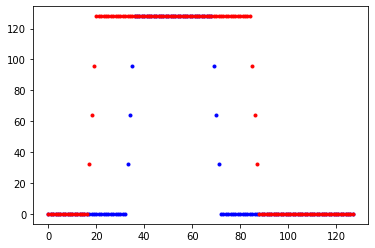

In [52]:
plt.plot(generateTemplate(position = 32, pulse_length=32, height=128), 'b.')
plt.plot(generateTemplate(position = 16, pulse_length=64, height=128), 'r.')
plt.show()

add some noise, and maybe shift the position





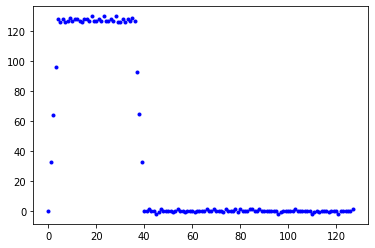

In [53]:
# Plot our data
plt.plot(generateTemplate(height=128, noise=1), 'b.')
plt.show()

## Create Templates for recognision

Generate a couple of templates, which have a pulse in them, and some without any data

35 42 2.0 115
49 23 2.0 108
51 17 1.5 72
20 51 0.8 57
19 50 2.1 46
50 28 2.6 123
24 34 2.0 102
38 55 2.4 38
3 35 2.1 66
29 43 2.6 44


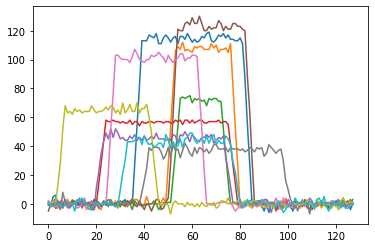

In [54]:
for i in range(10):
  width = np.random.randint(16, 64)               # width of 16 to 64
  position = np.random.randint(0, high=96-width) # arbitrary position
  noise = np.random.randint(1,30)/10.             # 0.1 to 3 LSB noise
  height = np.random.randint(32,128)              # pulse height of 32 to 128

  print(position, width, noise, height)
  plt.plot(generateTemplate(position = position, pulse_length = width, height=height, noise=noise))

plt.show()

# Building the ANN


### Purpose of the ANN
We want to do Pattern Recognition, based on the waveforms shown above.

The output parameters, which we want to reconstruct are:
*   Width
*   Position
*   height


Starting with importing all things, which we need for creating a model

In [55]:
# TensorFlow is an open source machine learning library
import tensorflow as tf
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras

In [56]:
# number of samples for training, testing etc.
SAMPLES = 10000

## Generate the samples
We want to do Pattern recognition, so we have to link the waveforms to the input parameters.

In [57]:
# scale parameters to get values between 0 and 1
SCALE_WIDTH = 32
SCALE_POS = 32
SCALE_HEIGHT = 255

In [58]:
# parameters for template generation
P_width = (16,32)
P_position = (16,24)
P_height = (32, 128)

In [59]:
# use fixed value for noise (1st try)
noise = 1 

y_values = []
x_values = []

# generate the waveforms
for i in range(SAMPLES):
  # use random settings
  width = np.random.randint( *P_width )       # width
  position = np.random.randint( *P_position ) # limit position into a certain window
  height = np.random.randint( *P_height )     # pulse height

  x_values.append( (width/SCALE_WIDTH, position/SCALE_POS, height/SCALE_HEIGHT) )
  y_values.append( generateTemplate(position = position, pulse_length = width, height=height, noise=noise) / SCALE_HEIGHT )

# debug printouts
#print(x_values[:2])
#print(y_values[:2])

### Look at the training data
Just make a 2D histogram of all templates.

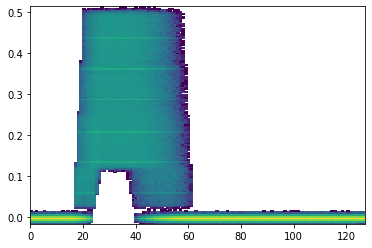

In [60]:
if True:
  plot_x = [ np.arange(128) for i in range(len(y_values)) ]
  plot_x = np.array(plot_x)
  plot_x = plot_x.flatten()
  plot_y = np.array(y_values)
  plot_y = plot_y.flatten()
  plt.hist2d(plot_x, plot_y, bins=128, norm=LogNorm())
  plt.show()

## Split the waveforms into Training, Testing and Validation

In [61]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)
print("using %d points for training and %d points for testing"%(TRAIN_SPLIT, TEST_SPLIT))

# convert data into numpy arrays
y_values = np.array(y_values) # parameters
x_values = np.array(x_values) # waveforms

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (len(x_train) + len(x_validate) + len(x_test) ) ==  SAMPLES

using 6000 points for training and 8000 points for testing


## Create the ANN

In [64]:
inputs = keras.Input(shape=(128,), name="waveform_input")

layer_cnt=0
x = keras.layers.Dense(64, name="layer_%d"%(layer_cnt))(inputs)
layer_cnt+=1

x = keras.layers.Dense(32, name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

# x = keras.layers.Dense(32, name="layer_%d"%(layer_cnt))(x)
# layer_cnt+=1

x = keras.layers.Dense(32,  name="layer_%d"%(layer_cnt))(x)
layer_cnt+=1

# final layer for classification
outputs = keras.layers.Dense(3, name="classification")(x)

model_1 = keras.Model(inputs=inputs, outputs=outputs)
model_1.summary()

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 waveform_input (InputLayer)  [(None, 128)]            0         
                                                                 
 layer_0 (Dense)             (None, 64)                8256      
                                                                 
 layer_1 (Dense)             (None, 32)                2080      
                                                                 
 layer_2 (Dense)             (None, 32)                1056      
                                                                 
 classification (Dense)      (None, 3)                 99        
                                                                 
Total params: 11,491
Trainable params: 11,491
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [65]:
# Train the model on our training data while validating on our validation set
# remember:
#     y = waveforms
#     x = truth parameters
# just do some trainings to see, whether this structure works or not

history_1 = model_1.fit(y_train, x_train, epochs=4, batch_size=25, validation_data=(y_validate, x_validate))

Epoch 1/4
240/240 [==============================] - 1s 4ms/step - loss: 0.0109 - accuracy: 0.8868 - val_loss: 0.0014 - val_accuracy: 0.9145
Epoch 2/4
240/240 [==============================] - 1s 3ms/step - loss: 0.0012 - accuracy: 0.9167 - val_loss: 0.0014 - val_accuracy: 0.9140
Epoch 3/4
240/240 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 0.9163 - val_loss: 0.0011 - val_accuracy: 0.9075
Epoch 4/4
240/240 [==============================] - 1s 3ms/step - loss: 0.0011 - accuracy: 0.9157 - val_loss: 0.0011 - val_accuracy: 0.9125


In [66]:
# fully train the network
history_1 = model_1.fit(y_train, x_train, epochs=500, batch_size=50, validation_data=(y_validate, x_validate))

# Save the model to disk
!mkdir -p saved_model
model_1.save('saved_model/STM32_AI_Test')

Epoch 1/500
120/120 [==============================] - 1s 5ms/step - loss: 0.0010 - accuracy: 0.9172 - val_loss: 0.0010 - val_accuracy: 0.9080
Epoch 2/500
120/120 [==============================] - 0s 4ms/step - loss: 0.0010 - accuracy: 0.9187 - val_loss: 0.0012 - val_accuracy: 0.9190
Epoch 3/500
120/120 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 0.9192 - val_loss: 0.0011 - val_accuracy: 0.9170
Epoch 4/500
120/120 [==============================] - 0s 4ms/step - loss: 0.0010 - accuracy: 0.9207 - val_loss: 0.0011 - val_accuracy: 0.9175
Epoch 5/500
120/120 [==============================] - 0s 4ms/step - loss: 9.9900e-04 - accuracy: 0.9202 - val_loss: 0.0011 - val_accuracy: 0.9020
Epoch 6/500
120/120 [==============================] - 0s 3ms/step - loss: 0.0010 - accuracy: 0.9167 - val_loss: 0.0011 - val_accuracy: 0.9130
Epoch 7/500
120/120 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 0.9195 - val_loss: 0.0012 - val_accuracy: 0.

INFO:tensorflow:Assets written to: saved_model/STM32_AI_Test/assets


# Evaluate the training performance

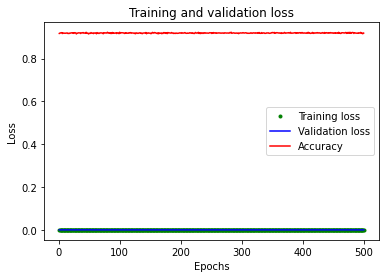

In [67]:
### Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
accuracy = history_1.history['accuracy']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.plot(epochs, accuracy, 'r', label='Accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
# evaluate the keras model
_, accuracy = model_1.evaluate(y_validate, x_validate)
print('Accuracy: %.2f' % (accuracy*100))

63/63 [==============================] - 0s 2ms/step - loss: 0.0011 - accuracy: 0.9225
Accuracy: 92.25


In [71]:
# Test a couple of waveforms
# remember:
#     y = waveforms
#     x = truth parameters

x_test = x_values[1]
y_test = np.array(generateTemplate(position = int(x_test[0]*SCALE_POS), 
                                   pulse_length = int(x_test[1]*SCALE_WIDTH), 
                                   height=int(x_test[2]*SCALE_HEIGHT), 
                                   noise=0
                                   )/SCALE_HEIGHT)

# waveform needs to be reshaped to be fed into ANN
y_test = y_test.reshape(1,128)

# try, whether we can reconstruct the parameters x_test from the waveform y_test
model_1.make_predict_function()
x_test_pred = np.array(model_1.predict(y_test)[0])

print("sample pulse created: ", x_test)
print("ANN reconstructed:    ", x_test_pred)

sample pulse created:  [0.8125     0.6875     0.42745098]
ANN reconstructed:     [0.85277414 0.72098994 0.35606655]


## Have a look at the reconstructed parameters

Get some random pulses, and have a look how they are reconstructed by the network.


In [72]:
# number of test waveforms
TEST_SAMPLES = 1000

In [74]:
waveforms = []        # generated waveforms
orig_parameters = []  # parameters, which are used for the generation
NN_parameters = []    # parameters, reconstructed by the NN

# vary the parameters to have a look a the performance outside the trained 
# parameter boundaries.
parameter_variation = 0.1

# increase the range of parameters in order to see, what is happening
T_width    = ( P_width[0]    * (1 - parameter_variation) , P_width[1]    * (1 + parameter_variation) )
T_position = ( P_position[0] * (1 - parameter_variation) , P_position[1] * (1 + parameter_variation) )
T_height   = ( P_height[0]   * (1 - parameter_variation) , P_height[1]   * (1 + parameter_variation) )

# generate the waveforms
for i in range(TEST_SAMPLES):
  # use random settings
  width = np.random.randint( *T_width )
  position = np.random.randint( *T_position )
  height = np.random.randint( *T_height )

  waveforms.append( np.array(generateTemplate(position = position, pulse_length = width, height=height, noise=noise) / SCALE_HEIGHT ) )
  orig_parameters.append( (width/SCALE_WIDTH, position/SCALE_POS, height/SCALE_HEIGHT) )

In [75]:
for i in range(TEST_SAMPLES):
  # waveform needs to be reshaped to be fed into ANN
  waveform = waveforms[i].reshape(1,128)
  NN_parameters.append( np.array( model_1.predict(waveform)[0]) )


Plot the distributions

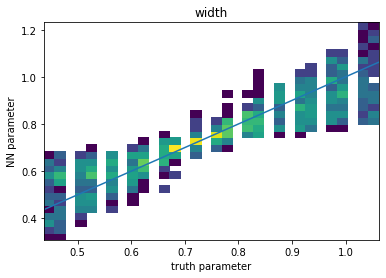

In [76]:
plot_x = [k[0] for k in orig_parameters]
plot_y = [k[0] for k in NN_parameters]
plt.hist2d(plot_x, plot_y, bins=32, norm=LogNorm())
plt.vlines(np.array(P_width),ymin=0, ymax=100)
plt.plot( [np.min(plot_x), np.max(plot_x)], [np.min(plot_x), np.max(plot_x)])
plt.title("width")
plt.ylabel("NN parameter")
plt.xlabel("truth parameter")
plt.show()

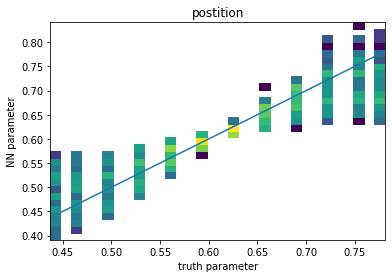

In [77]:
plot_x = [k[1] for k in orig_parameters]
plot_y = [k[1] for k in NN_parameters]
plt.hist2d(plot_x, plot_y, bins=32, norm=LogNorm())
plt.vlines(np.array(P_position),ymin=0, ymax=100)
plt.plot( [np.min(plot_x), np.max(plot_x)], [np.min(plot_x), np.max(plot_x)])
plt.title("postition")
plt.ylabel("NN parameter")
plt.xlabel("truth parameter")
plt.show()

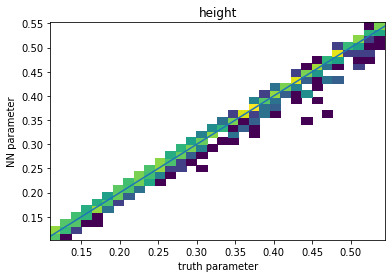

In [78]:
plot_x = [k[2] for k in orig_parameters]
plot_y = [k[2] for k in NN_parameters]
plt.hist2d(plot_x, plot_y, bins=32, norm=LogNorm())
plt.vlines(np.array(P_height),ymin=0, ymax=1000)
plt.plot( [np.min(plot_x), np.max(plot_x)], [np.min(plot_x), np.max(plot_x)])
plt.title("height")
plt.ylabel("NN parameter")
plt.xlabel("truth parameter")
plt.show()

# What happens at zero input?
What if the input array is all zero?

In [79]:
# waveform needs to be reshaped to be fed into ANN
waveform = np.zeros(128)
waveform = waveform.reshape(1,128)
print( model_1.predict(waveform)[0] )

[0.7263223  0.60942656 0.00425582]


# Export to STM32

following:
This [tutorial](https://www.digikey.de/en/maker/projects/tinyml-getting-started-with-stm32-x-cube-ai/f94e1c8bfc1e4b6291d0f672d780d2c0) from DigiKey 

In [80]:
# settings
tflite_model_name = 'pulse_reco'  # Will be given .tflite suffix
c_model_name = 'pulse_reco'       # Will be given .h suffix

In [81]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model_1)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # option OPTIMIZE_FOR_SIZE is deprecated
tflite_model = converter.convert()

open(tflite_model_name+'.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp38wtg8pq/assets


INFO:tensorflow:Assets written to: /tmp/tmp38wtg8pq/assets


13856

For usage inside the [STM32Cube.AI](https://www.st.com/content/st_com/en/support/learning/stm32-education/stm32-moocs/Introduction_to_STM32CubeAI_MOOC.html) it is sufficient to just have the tensorflow light model. The special export seems not be needed.

We have to define a special function, which exports our data into a H-file, which can be later used and included into our microcontroller code.

The function is from https://gist.github.com/ShawnHymel/79237fe6aee5a3653c497d879f746c0c

## Test the TFlite model

In [82]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_name+".tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

input_data = np.array( y_test, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])[0]

print("sample pulse created:    ", x_test)
print("TFlite reconstructed:    ", output_data)

sample pulse created:     [0.8125     0.6875     0.42745098]
TFlite reconstructed:     [0.85415703 0.722279   0.36138958]


# Use quantization aware training
Translate the model into int8 and fine tune it. Then export it again for STM32

## Install all prerequisites

In [ ]:
 !pip install -q tensorflow
 !pip install -q tensorflow-model-optimization

     |████████████████████████████████| 462 kB 5.5 MB/s 
     |████████████████████████████████| 234 kB 5.3 MB/s 


## Convert the model into a quantization aware one

In [ ]:
import tensorflow_model_optimization as tfmot

quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model_1)

# `quantize_model` requires a recompile.
#q_aware_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

q_aware_model.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

q_aware_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 waveform_input (InputLayer)  [(None, 128)]            0         
                                                                 
 quantize_layer (QuantizeLay  (None, 128)              3         
 er)                                                             
                                                                 
 quant_layer_0 (QuantizeWrap  (None, 64)               8261      
 perV2)                                                          
                                                                 
 quant_layer_1 (QuantizeWrap  (None, 32)               2085      
 perV2)                                                          
                                                                 
 quant_layer_2 (QuantizeWrap  (None, 32)               1061      
 perV2)                                                      

## Do a short training to finetune the model

In [ ]:
history_q = q_aware_model.fit(y_train, x_train, batch_size=50, epochs=10, validation_split=0.1)

Epoch 1/10
108/108 [==============================] - 0s 3ms/step - loss: 13.0552 - accuracy: 1.0000 - val_loss: 10.3368 - val_accuracy: 1.0000
Epoch 2/10
108/108 [==============================] - 0s 3ms/step - loss: 8.6237 - accuracy: 1.0000 - val_loss: 5.8032 - val_accuracy: 1.0000
Epoch 3/10
108/108 [==============================] - 0s 4ms/step - loss: 5.7229 - accuracy: 1.0000 - val_loss: 3.9649 - val_accuracy: 1.0000
Epoch 4/10
108/108 [==============================] - 0s 3ms/step - loss: 4.1082 - accuracy: 1.0000 - val_loss: 3.0680 - val_accuracy: 1.0000
Epoch 5/10
108/108 [==============================] - 0s 3ms/step - loss: 3.3236 - accuracy: 1.0000 - val_loss: 2.3431 - val_accuracy: 1.0000
Epoch 6/10
108/108 [==============================] - 0s 3ms/step - loss: 2.4614 - accuracy: 1.0000 - val_loss: 1.9965 - val_accuracy: 1.0000
Epoch 7/10
108/108 [==============================] - 0s 3ms/step - loss: 2.0851 - accuracy: 1.0000 - val_loss: 1.8056 - val_accuracy: 1.0000
Epoc

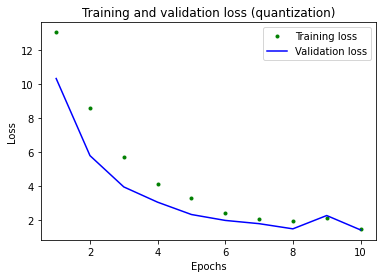

In [ ]:
### Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
q_train_loss = history_q.history['loss']
q_val_loss = history_q.history['val_loss']

epochs = range(1, len(q_train_loss) + 1)

plt.plot(epochs, q_train_loss, 'g.', label='Training loss')
plt.plot(epochs, q_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss (quantization)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # option OPTIMIZE_FOR_SIZE is deprecated
tflite_model = converter.convert()

open(tflite_model_name+'_qaware'+'.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0ov2idoc/assets


INFO:tensorflow:Assets written to: /tmp/tmp0ov2idoc/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


15008

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)

input_type = interpreter.get_input_details()[0]['dtype']
print('input dtype:  ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output dtype: ', output_type)

input dtype:   <class 'numpy.float32'>
output dtype:  <class 'numpy.float32'>


## Check quantization aware model

In [ ]:
_, baseline_model_accuracy = model_1.evaluate(
    y_validate, x_validate, verbose=0)

_, q_aware_model_accuracy = q_aware_model.evaluate(
   y_validate, x_validate, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)
print('Quant test accuracy:   ', q_aware_model_accuracy)

Baseline test accuracy: 0.6972407698631287
Quant test accuracy:    1.0


In [ ]:
qx_test_pred = np.array( q_aware_model.predict(y_test)[0])
x_test_pred  = np.array( model_1.predict(y_test)[0])

print("sample pulse created:    ", x_test)
print("ANN reconstructed:       ", x_test_pred)
print("ANN quant reconstructed: ", qx_test_pred)

sample pulse created:     [21 18 49]
ANN reconstructed:        [20.678125 20.212816 49.485893]
ANN quant reconstructed:  [20.646603 21.126755 49.455814]


## Test the qaware TFlite model


In [66]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_name+'_qaware'+".tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

input_type = interpreter.get_input_details()[0]['dtype']
print('input dtype:  ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output dtype: ', output_type)
print()

input_data = np.array( y_test, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])[0]
print(output_data)

input dtype:   <class 'numpy.float32'>
output dtype:  <class 'numpy.float32'>

[20.166449 20.166449 48.97566 ]
